## A Satellite View of Santa Barbara Flooding in January 2023 (Part 1)

In early January 2023, massive floods hit Santa Barbara county, shifting the landscape in profound ways:
- Very dry lakes (e.g. Lake Cachuma) quickly filled and overflowed
- There was substantial beach erosion, making beaches inaccessible in some places
- Landslides affected the mountains, wiping out established hiking trails and forcing closures of others for many months

Below is a map of estimated precipitation during the event, showing Santa Barbara receiving about 12 inches of rain and the nearby 
mountains receiving much more!
<!-- ![](California_Total_Precip_to_January_11.jpg) -->
<img src="California_Total_Precip_to_January_11.jpg" alt="drawing" width="800"/>

The goal of these notebooks is to survey the true extent of these floods using satellite imagery taken in a 
variety of bands and from multiple instruments, namely Sentinel-2 (optical and IR), and Sentinel-1 (microwave synthetic aperture radar)

#### Tasks
1. Create some useful visualizations showing the changing landscape over time, for instance time-series movies in each band, and 
some interactive maps allowing one to toggle back and forth between optical images, SAR images, etc. 
2. Measure the change in plant growth (e.g. quantify NDVI) due to all the rainfall 
3. Conduct a more rigorous landscape change analysis using e.g. the iMad algorithm
4. Test the limits of satellite resolution to see if changes to some trails (only a few meters wide) that I know to be affected will show up in the images

We'll tackle parts 1 and 2 in this notebook and save parts 3 and 4 for a second notebook



In [53]:
# Running list of requirements:
# geopandas
# ffmpeg
# geemap

import ee
import IPython.display as disp
import geemap
import geopandas as gpd
import json
import folium
%matplotlib inline

#ee.Authenticate() # instead type "earthengine authenticate" on command line
ee.Initialize()

# Test to make sure it's working
assert ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo(), "Not working"

### Helpful time-series visualizations
Let's follow a few helpful tutorials and modify them. The first task is to create a helpful visualization of optical vs SAR backscatter over our AOI (Santa Barbara, CA) during the relevant time period (January 2023). We'll get optical from Sentinel-2 and SAR from Sentinel-1a, and look for images during that time period. 

In [54]:
# Can use geojson.io to get the following area of interest (aoi)
SB_GeoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            -120.02162997431329,
            34.65968762774044
          ],
          [
            -120.02991856052506,
            34.312776459833444
          ],
          [
            -119.47642519238346,
            34.30897295967435
          ],
          [
            -119.48379282457168,
            34.65286961735019
          ],
          [
            -120.02347188236035,
            34.66044514982775
          ]
        ],
        "type": "LineString"
      }
    }
  ]
}

coords = SB_GeoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)



In [55]:
start_date = ee.Date('2022-12-02')
end_date = start_date.advance(30,'days')

date_filter = ee.Filter.date(start_date, end_date)


SAR = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD') 
                       .filterBounds(aoi) 
                       .filter(date_filter) 
                       .first() 
                       .clip(aoi))
S2 = ee.Image(ee.ImageCollection('COPERNICUS/S2_HARMONIZED') 
                       .filterBounds(aoi) 
                       .filter(date_filter)
                       .filter('CLOUDY_PIXEL_PERCENTAGE < 5')
                       .first() 
                       .clip(aoi))


Let's print off the SAR (Sentinel-1) and Sentinel-2 bands we can work with, just to make sure things are working, and let's create an image from the VV band

In [56]:
print("SAR band names:" + str(SAR.bandNames().getInfo()))
print("Sentinel-2 band names:" + str(S2.bandNames().getInfo()))
url = SAR.select('VV').getThumbURL({'min': -20, 'max': 0})
disp.Image(url=url, width=800)

SAR band names:['VV', 'VH', 'angle']
Sentinel-2 band names:['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'QA10', 'QA20', 'QA60']


In [57]:
# Make sure optical works too
url = S2.select('B2').getThumbURL({'min': 0, 'max': 3000})
disp.Image(url=url, width=600)

Ok, it works! Let's now factor in the other SAR bands and compare a composite SAR image to a Sentinel-2 version. To do this, we'll first use Folium, which allows you to make interactive maps, and then we'll test out some of the geemap functionality for sliding between images and creating time-series movies.

We'll follow this tutorial for a while, including some code copied directly from it: https://colab.research.google.com/github/google/earthengine-community/blob/master/tutorials/detecting-changes-in-sentinel-1-imagery-pt-1/index.ipynb#scrollTo=VIiyf6azf4mU

In [58]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [59]:
location = aoi.centroid().coordinates().getInfo()[::-1]

# Make an RGB color composite image (VV,VH,VV/VH).
SAR_rgb_image = ee.Image.rgb(SAR.select('VV'),
                   SAR.select('VH'),
                   SAR.select('VV').divide(SAR.select('VH')))

S2_image = ee.Image.rgb(S2.select('B2'),
                        S2.select('B3'),
                        S2.select('B4'))

# Create the map object.
m = folium.Map(location=location, zoom_start=12)

# Add the S1 rgb composite to the map object.
m.add_ee_layer(SAR_rgb_image, {'min': [-20, -20, 0], 'max': [0, 0, 2]}, 'Sentinel-1 (SAR)')

# Add S2 image
m.add_ee_layer(S2_image, {'min': [0, 0, 0], 'max': [3000, 3000, 3000]}, 'Sentinel-2')

# Add a layer control panel to the map.
m.add_child(folium.LayerControl())

# Display the map.
display(m)

Cool! We can flip back and forth between the two images. Now let's really start comparing "before flood" to "after flood" images. Let's first make time-series of both optical and SAR images to see what happens over the course of several months before and after the January floods

In [60]:
# timelapse for a sentinel-1 collection following the geemap documentation: https://book.geemap.org/chapters/09_timelapse.html#sentinel-1-timelapse
timelapse = geemap.sentinel1_timelapse(
    aoi,
    out_gif='sentinel1.gif',
    start_year=2022,
    end_year=2023,
    start_date='09-01',
    end_date='04-01',
    bands=['VV'],
    frequency='day',
    vis_params={"min": -30, "max": 0},
    palette="Greys",
    frames_per_second=3,
    title='Sentinel-1 Timelapse',
    add_colorbar=True,
    colorbar_bg_color='gray',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/chadbustard/Desktop/Industry/Google Earth Engine/SantaBarbara/sb_flooding/sentinel1.gif
ffmpeg is not installed on your computer.


Output()

In [61]:
# Same for sentinel-2 optical
timelapse = geemap.sentinel2_timelapse(
    aoi,
    out_gif='sentinel2.gif',
    start_year=2022,
    end_year=2023,
    start_date='09-01',
    end_date='04-01',
    frequency='month',
    bands=['SWIR1', 'NIR', 'Red'],
    frames_per_second=3,
    title='Sentinel-2 Timelapse',
)
geemap.show_image(timelapse)

Generating URL...
Please wait ...
The GIF image has been saved to: /Users/chadbustard/Desktop/Industry/Google Earth Engine/SantaBarbara/sb_flooding/sentinel2.gif
ffmpeg is not installed on your computer.


Output()

These timelapses are fun, but they aren't great for showing fine detailed changes because they rely on the user to pick up on the changes themselves, which works best if the change is really big. One example of such a big change, though, is the lake in the upper left (Lake Cachuma) growing substantially in early 2023! This shows up well in both Sentinel-2 and Sentinel-1 (SAR is good for mapping water because it appears black, since incident waves scatter directly away from a flat surface rather than reflecting back to the satellite)

## Quantifying Normalized Difference Vegetation Index (NDVI)

Following that lake growth, the color of the Sentinel-2 image changes in many locations from red to green! We've set the rgb bands to be "SWIR1", "NIR", and "Red", meaning there is a pretty large conversion from SWIR to NIR. Let's see if this is due to increased vegetation. For that, geemap allows you to easily load in MODIS vegetation indices, which *would* be trivial, but Terra spiraled out before our time window beginning in late 2022. So we'll do this one manually using Sentinel-2 data. 

As a reminder, NDVI = "normalized difference vegetation index" = (NIR - Red)/(NIR + Red), which ranges from -1 to 1. It is used to quantify the health and density of vegetation, which fluctuates enormously in southern California throughout the year due to long, dry summers followed by wet winters (well, usually...especially in 2022/2023)

In [62]:
"Before flood"
start_date = ee.Date('2022-11-01')
end_date = ee.Date('2023-11-20')

date_filter = ee.Filter.date(start_date, end_date)

s2_before_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterBounds(aoi).filter(date_filter).filter('CLOUDY_PIXEL_PERCENTAGE < 50')
before_image = ee.Image(s2_before_collection.first()).clip(aoi)

# "After flood"
start_date = ee.Date('2023-03-01')
end_date = ee.Date('2023-03-21')

date_filter = ee.Filter.date(start_date, end_date)

s2_after_collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterBounds(aoi).filter(date_filter).filter('CLOUDY_PIXEL_PERCENTAGE < 50')
after_image = ee.Image(s2_after_collection.first().clip(aoi))

# Now get NDVI
ndvi_before = before_image.normalizedDifference(['B5', 'B4']).rename('NDVI') # shortcut to get ndvi instead of subtracting and dividing
ndvi_after = after_image.normalizedDifference(['B5', 'B4']).rename('NDVI') # shortcut to get ndvi instead of subtracting and dividing



One of the most fun ways to visualize before and after changes is with a split map. geemap lets us do this pretty easily

In [63]:
# Create a fun split map with November on the left and March on the right
ndviParams = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
SB_split_map = geemap.Map()
SB_split_map.centerObject(ndvi_after, 12)
# left_layer = geemap.ee_tile_layer(ndvi_before, ndviParams, 'November')
# right_layer = geemap.ee_tile_layer(ndvi_after, ndviParams, 'March')
left_layer = geemap.ee_tile_layer(ndvi_before, ndviParams, 'November')
right_layer = geemap.ee_tile_layer(ndvi_after, ndviParams, 'March')
SB_split_map.split_map(left_layer,right_layer)

SB_split_map

Map(center=[34.48508723089384, -119.82681327243162], controls=(ZoomControl(options=['position', 'zoom_in_text'…

### Historical NDVI

We can see above that NDVI changes significantly between November (left) and March (right). This was caused by the large amount of rainfall in early January, but I'm curious whether this happens every year. To check that, we add an NDVI band to a collection of images and then calculate the mean NDVI in different representative regions (doing it for the entire Santa Barbara aoi exceeds computation limits)

In [64]:
import pandas as pd
import time

# For this one, we'll just filter the date to be pretty close to the known rainfall event in early January
start_date = ee.Date('2022-11-01')
end_date = ee.Date('2023-03-30')

date_filter = ee.Filter.date(start_date, end_date)

s2_image_collection = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi).filter(date_filter).filter('CLOUDY_PIXEL_PERCENTAGE < 50')

# Function to add NDVI band to each image in a collection
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))

# Use the addNDVI function on each image in s2_image_collection
s2_ts_ndvi = s2_image_collection.map(addNDVI)

# Let's make sure we have quite a few timestamps to work with
acq_times = s2_ts_ndvi.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]


['11/02/22',
 '11/02/22',
 '11/02/22',
 '11/12/22',
 '11/12/22',
 '11/12/22',
 '11/14/22',
 '11/14/22',
 '11/17/22',
 '11/17/22',
 '11/19/22',
 '11/19/22',
 '11/22/22',
 '11/22/22',
 '11/22/22',
 '11/27/22',
 '11/27/22',
 '11/27/22',
 '11/29/22',
 '11/29/22',
 '12/07/22',
 '12/07/22',
 '12/07/22',
 '12/14/22',
 '12/14/22',
 '01/01/23',
 '01/01/23',
 '01/03/23',
 '01/06/23',
 '01/06/23',
 '01/06/23',
 '01/16/23',
 '01/16/23',
 '01/16/23',
 '01/21/23',
 '01/21/23',
 '01/21/23',
 '01/26/23',
 '01/26/23',
 '01/26/23',
 '01/31/23',
 '01/31/23',
 '01/31/23',
 '02/05/23',
 '02/05/23',
 '02/05/23',
 '02/12/23',
 '02/15/23',
 '02/15/23',
 '02/15/23',
 '02/20/23',
 '02/20/23',
 '02/20/23',
 '02/22/23',
 '02/25/23',
 '03/02/23',
 '03/02/23',
 '03/02/23',
 '03/07/23',
 '03/07/23',
 '03/07/23',
 '03/09/23',
 '03/09/23',
 '03/12/23',
 '03/12/23',
 '03/17/23',
 '03/17/23',
 '03/22/23',
 '03/24/23',
 '03/24/23',
 '03/27/23',
 '03/27/23',
 '03/27/23',
 '03/29/23',
 '03/29/23']

Good! We have plenty of NDVI images during our time period. Let's go ahead and pick some interesting regions to calculate average NDVI. The first is an open field in Goleta, CA (suburb of Santa Barbara) that shows a ton of change in NDVI, and the second is a larger region in the backcountry

In [66]:
# Following this is helpful here... https://worldbank.github.io/OpenNightLights/tutorials/mod4_1_time_series_charts.html

# Point selected in a field near Goleta, CA, with a buffer in meters around our point of interest
field = ee.Geometry.Point([-119.86272763837708, 34.43892291923153]).buffer(500)

rural_aoi = ee.Geometry.Point([-119.88827311361248, 34.52637713334907]).buffer(1000)

def field_mean(img):
    """Calculates the mean within this area (field) for an individual image"""
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=field, scale=30).get('NDVI')
    return img.set('date', img.date().format()).set('mean',mean)


def rural_mean(img):
    """Same but for the rural backcountry region"""
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=rural_aoi, scale=30).get('NDVI')
    return img.set('date', img.date().format()).set('mean',mean)


def calc_mean_over_region(imageCol, meanFunc):
    """Calculate mean for each image and then convert to a workable Pandas DataFrame"""
    
    # Calculate mean for each timestamp
    field_imgs = imageCol.map(meanFunc)

    # Convert from ImageCollection to a nested list we can convert to a Pandas DataFrame
    nested_list = field_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

    # Convert to a DataFrame
    df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

    # Convert timestamp to datetime
    df['date'] = pd.to_datetime(df['date'])

    return df


df_s2_field = calc_mean_over_region(s2_ts_ndvi, field_mean)
df_s2_rural = calc_mean_over_region(s2_ts_ndvi, rural_mean)

df_s2_field.head()


,date,mean
0,2022-11-02 18:54:48,0.119682
1,2022-11-02 18:54:46,0.120464
2,2022-11-12 18:54:50,0.116953
3,2022-11-12 18:54:48,0.118162
4,2022-11-17 18:54:52,0.115715


Let's show where these regions are before we plot their mean NDVI over time

In [67]:
fieldMap = geemap.Map()
fieldMap.centerObject(field, zoom=11)
fieldMap.addLayer(field, {}, "Goleta Field")
fieldMap.addLayer(rural_aoi, {}, "Backcountry Region")
fieldMap.addLayerControl()
fieldMap

Map(center=[34.43892343216697, -119.86272762112559], controls=(WidgetControl(options=['position', 'transparent…

Let's start by plotting the field and focusing on the 2022/2023 winter season

[Text(0.5, 1.0, 'NDVI in Goleta field')]

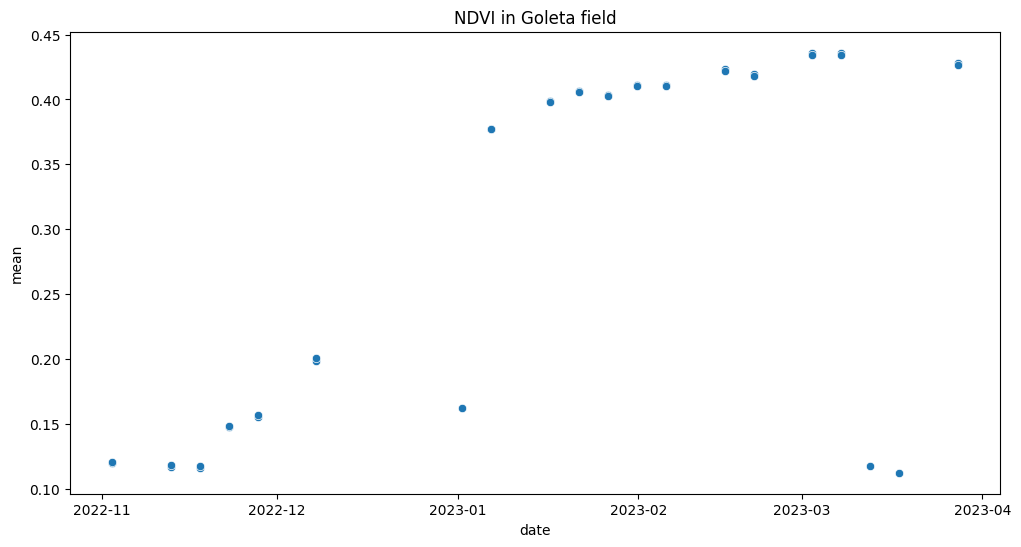

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=df_s2_field, x='date',y='mean', ax=ax).set(title="NDVI in Goleta field")

That's a massive increase in a short amount of time! But how abnormal is it? Let's plot this over a number of years and see how the winter of 2022/2023 compares.

In [69]:
start_date = ee.Date('2014-11-01')
end_date = ee.Date('2023-06-30')

date_filter = ee.Filter.date(start_date, end_date)

s2_image_collection = ee.ImageCollection('COPERNICUS/S2').filterBounds(aoi).filter(date_filter).filter('CLOUDY_PIXEL_PERCENTAGE < 50')

s2_ts_ndvi = s2_image_collection.map(addNDVI)

df_s2_field_multiyear = calc_mean_over_region(s2_ts_ndvi, field_mean)


[Text(0.5, 1.0, 'NDVI')]

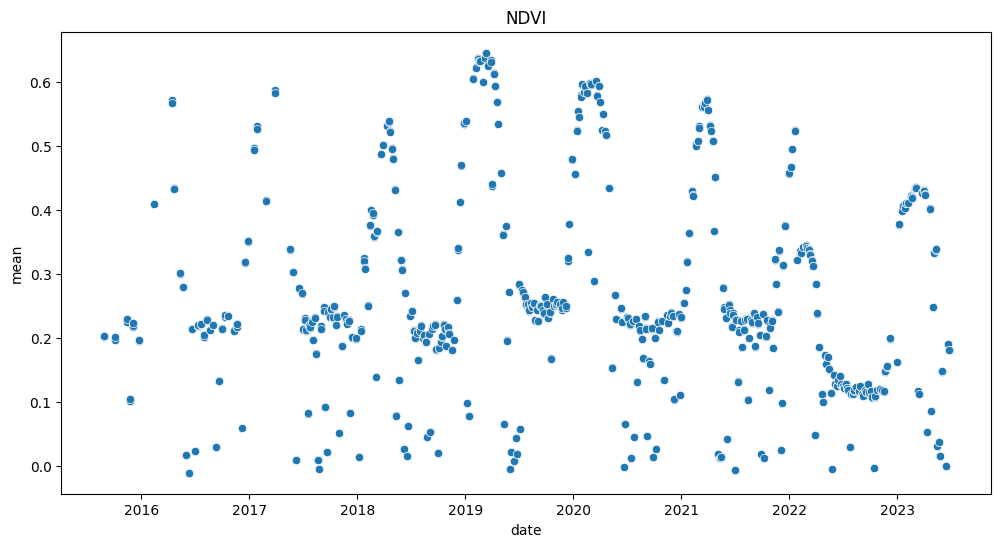

In [70]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=df_s2_field_multiyear, x='date',y='mean', ax=ax).set(title="NDVI")

Interestingly, the mean NDVI in winter 2022/2023 is on the lower end compared to previous years. Maybe the land owner changed something on a local scale...let's take a look at the mean over the rural area and see how it compares to previous years

[Text(0.5, 1.0, 'NDVI in rural area')]

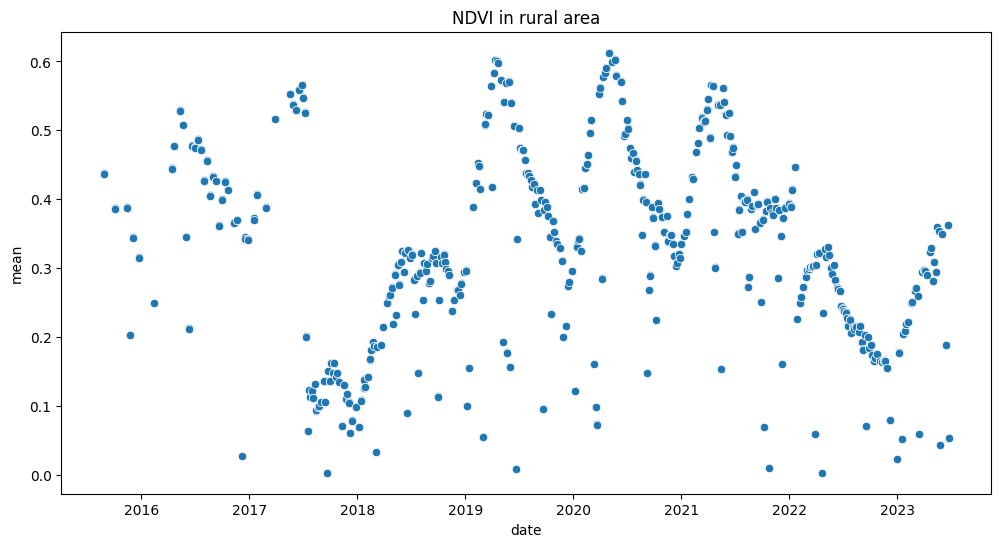

In [71]:
df_s2_rural_multiyear = calc_mean_over_region(s2_ts_ndvi, rural_mean)

fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=df_s2_rural_multiyear, x='date',y='mean', ax=ax).set(title="NDVI in rural area")

Yikes, either the last few years of drought haven't been kind to the Santa Barbara backcountry, even with extreme rainfall this past winter, or something is amiss. Let's check this vs Landsat NDVI

In [72]:
Ls_image_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterBounds(aoi).filter(date_filter)

def add_Ls_NDVI(image):
    return image.addBands(image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI'))

Ls_ts_ndvi = Ls_image_collection.map(add_Ls_NDVI)

Ls_imgs = Ls_ts_ndvi.map(rural_mean)

# Convert from ImageCollection to a nested list we can conver to a Pandas DataFrame
nested_list = Ls_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

# Convert to a DataFrame
df_Ls = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

# Convert timestampe to datetime
df_Ls['date'] = pd.to_datetime(df_Ls['date'])

df_Ls


,date,mean
0,2014-11-15 18:34:43,0.174219
1,2014-12-01 18:34:42,0.020606
2,2014-12-17 18:34:38,0.166666
3,2015-01-02 18:34:32,0.166597
4,2015-01-18 18:34:30,0.178915
...,...,...
190,2023-04-14 18:34:04,0.236873
191,2023-04-30 18:33:59,0.300740
192,2023-05-16 18:33:46,0.316127
193,2023-06-01 18:33:49,0.149927


[Text(0.5, 1.0, 'NDVI (Landsat) in rural area')]

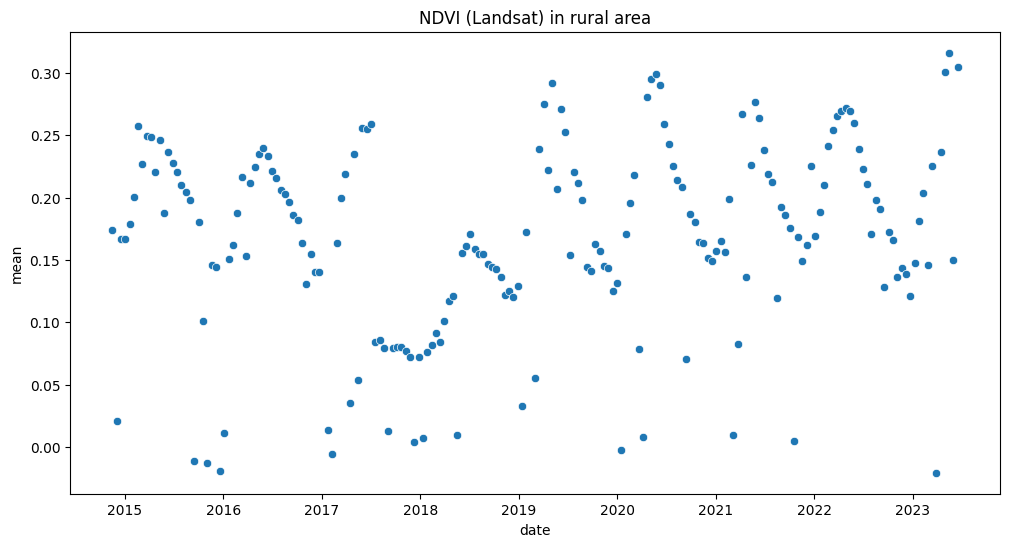

In [73]:
fig, ax = plt.subplots(figsize=(12,6))
#sns.scatterplot(data=df2, x='date',y='mean', ax=ax).set(title="NDVI")
sns.scatterplot(data=df_Ls, x='date',y='mean', ax=ax).set(title="NDVI (Landsat) in rural area")

The Landsat derived NDVI are strangely quite different from the Sentinel-2 NDVI. I'll leave this for future work and get to it another day

# Statistically rigorous landscape change detection

Ok, let's look for changes in a bit more rigorous way than just timeseries plots of averages and videos of Lake Cachuma filling up. 

First, let's focus again on NDVI and show how we can make a statistically rigorous quantification of change. To do this, we'll focus on the ratio between NDVI before and after the flood (i.e. comparing November to March). We choose to measure the *ratio* rather than the *difference* because a difference measure won't easily pick up on changes in regions with small NDVI: the difference between two large numbers is generally larger than the difference between two small numbers. The ratio is a much better, more sensitive metric

In [74]:
from scipy.stats import norm, gamma, f, chi2
import matplotlib.pyplot as plt
import numpy as np


# Get the "after" / "before" ratio
ratio = ndvi_after.divide(ndvi_before)

# Get the "after" - "before" 
diff = ndvi_after.subtract(ndvi_before)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 5, 'palette': ['black', 'white']}, 'After/Before')
mp.add_ee_layer(diff,
                {'min': -0.5, 'max': 1, 'palette': ['black', 'white']}, 'After - Before')
mp.add_child(folium.LayerControl())

display(mp)

The white areas are where the NDVI ratio or difference is highest. They overlap well with what we saw by eye earlier, including in our "field" region, which appears as a block of white in both map layers.

We can also dive a bit deeper and look at the differences between individual visual bands:

In [79]:
location = aoi.centroid().coordinates().getInfo()[::-1]
visMap = folium.Map(location=location, zoom_start=12)
visirbands = ['B2','B3','B4','B8','B11','B12']
irbands = ['B8','B11','B12']
visbands = ['B2','B3','B4']

diff = before_image.subtract(after_image).select(visbands)
visMap.add_ee_layer(before_image.select(visbands), {'min': [0, 0, 0], 'max': [3000, 3000, 3000]}, 'November')
visMap.add_ee_layer(after_image.select(visbands), {'min': [0, 0, 0], 'max': [3000, 3000, 3000]}, 'March')
visMap.add_ee_layer(diff, {'min': [0, 0, 0], 'max': [1000, 1000, 1000]}, 'Difference')
visMap.add_child(folium.LayerControl())

visMap

We can also check out just the IR bands

In [80]:
location = aoi.centroid().coordinates().getInfo()[::-1]
visMap = folium.Map(location=location, zoom_start=12)

diff = before_image.subtract(after_image).select(irbands)
visMap.add_ee_layer(before_image.select(irbands), {'min': [0, 0, 0], 'max': [3000, 3000, 3000]}, 'November')
visMap.add_ee_layer(after_image.select(irbands), {'min': [0, 0, 0], 'max': [3000, 3000, 3000]}, 'March')
visMap.add_ee_layer(diff, {'min': [0, 0, 0], 'max': [1000, 1000, 1000]}, 'Difference')
visMap.add_child(folium.LayerControl())

visMap

# 

## IMAD Change Detection

The above is kind of fun and allows us to see some useful changes in NDVI and in optical/IR imagery overall; however, it does require some user subjectivity to determine where and how big the changes are. To assess landscape change in a more rigorous way, we can use what's known as the iMAD algorithm (iterative Multivariate Alteration Detection). I'll follow this tutorial (https://colab.research.google.com/github/mortcanty/eeimad/blob/main/src/gee_change_detection_pt_1.ipynb#scrollTo=kc_pwScrphK1) to first copy publicly available code for the MAD algorithm before presenting and using the iMAD algorithm.

#### MAD Variates

Previously, what we did is calculate the change between images, treating them as vectors in spectral space (each component is a different spectral band). Now, we aim to transform the image vectors such that they are as similar as possible before taking their difference, therefore amplifying the genuine differences. We do this through a Canonical Change Analysis (similar to Principal Components Analysis), which will transform from spectral space to a space of *canonical variates* ordered by correlation (similar to PCA where you write the vectors as combinations of eigenvectors). The components of the difference vector are then called the MAD variates.


#### The iMAD Method

The iMAD method, which we'll copy from here (https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt2), iteratively applies the MAD transformation to pixel regions where there has been no physical change. This helps to define an invariant background, on top of which we can assess change. That is, it tries to remove the image differences that arise purely from noise, e.g. instrument or atmospheric effects -- without this iterative scheme, even two images that have *zero* difference in reflectance would show changes. 

Most statistically speaking, the motivation for the iMAD method is as follows:

- One can show that the sum of squares of the MAD variates, $Z = \Sigma_{i}^{N} (\frac{M_{i}}{\sigma_{M_{i}}})^{2}$ represents a likelihood ratio test statistic, where $\sigma^{2}_{M_{i}} = var(Im1_{i} - Im2_{i}) = 2(1-cov(Im1_{i},Im2_{i}))$ where i denotes the image component in the new vector space after MAD transformation, not the original spectral space. 

- Our hypothesis is that Z is $\chi^{2}$-distributed, as we expect the influence of random effects to be, and our p-value measures the extent to which this is true. 

- The iMAD algorithm iteratively weights each image pixel by the p-value before re-sampling the images, calculating statistics, and repeating. The end result (once some stopping criterion, such as a threshold on change in canonical correlations cov(Im1,Im2), is met) is to gradually reduce the change observations. 



In [81]:
from iMAD import run_imad
imad_exports = run_imad(aoi, before_image.select(visirbands), after_image.select(visirbands), maxiter = 5)

im_imad = ee.Image(imad_exports).select(0, 1, 2, 3, 4, 5)
im_z = ee.Image(imad_exports).select(6).rename('Z')
niter = im_imad.get('niter').getInfo()
rhos = ee.List(im_imad.get('rhos')).getInfo()
print('iteratons: %i'%niter)
print('canonical correlations: %s'%rhos)

iteratons: 5
canonical correlations: [0.9977727290168115,0.9049414384507763,0.8339562554867358,0.6878471083363658,0.6401567858414736,0.5464028674589743]


In [82]:
# Install the ee_jupyter package.
from iMAD import display_ls
import os
try:
  import ee_jupyter
except ModuleNotFoundError:
  print('ee_jupyter was not found. Installing now...')
  result = os.system('pip -q install earthengine-jupyter')
  import ee_jupyter
print(f'ee_jupyter (version {ee_jupyter.__version__}) '
        f'is installed.')

from ee_jupyter.ipyleaflet import Map

location = aoi.centroid().coordinates().getInfo()[::-1]
M1 = Map(**{'center': location, 'zoom': 11})
display_ls(before_image.select(visbands), M1, 'November')
display_ls(after_image.select(visbands), M1, 'March')
display_ls(im_imad.select('iMAD1', 'iMAD2', 'iMAD3'), M1, 'iMAD123', True)

M1

ee_jupyter (version 0.0.7) is installed.


Map(center=[34.48312300154308, -119.7534481913798], controls=(ZoomControl(options=['position', 'zoom_in_text',…

As in the tutorial, it would be useful to run a clustering model to get a sense of what the different colors could mean. This is obvious in the case of "clear-cutting" of forest, where regions with lots of clear-cutting will look very different than regions that haven't changed. The flooding case is likely more complicated, since we can expect changes to fall into many different possible categories:   
-- Growth in vegetation (and of different types of vegetation, each imprinting different changes to NDVI)  
-- Flooding / increase in water levels  
-- Washout from flooding, i.e. maybe some scars are left on the landscape due to mudslides  

Let's set up a quick clustering model anyway and see if we can gleam any info...

In [83]:
# Standardize to no change sigmas.
sigma2s = ee.Image.constant([2*(1-x) for x in eval(rhos)])
im_imadstd = im_imad.divide(sigma2s.sqrt())
# Collect training data.
training = im_imadstd.sample(region=aoi, scale=20, numPixels=50000)
# Train the clusterer.
clusterer = ee.Clusterer.wekaKMeans(4).train(training)
# Classify the standardized imad image.
result = im_imadstd.cluster(clusterer)

In [84]:
M2 = Map(**{'center': location, 'zoom': 13})
display_ls(before_image.select(visbands), M2, 'November')
display_ls(after_image.select(visbands), M2, 'March')
cluster0 = result.updateMask(result.eq(0))
cluster1 = result.updateMask(result.eq(1))
cluster2 = result.updateMask(result.eq(2))
cluster3 = result.updateMask(result.eq(3))
palette = ['red', 'yellow', 'blue', 'black']
vis_params = {'min': 0, 'max': 3, 'palette': palette}
M2.addLayer(cluster0, vis_params, 'Cluster 0')
M2.addLayer(cluster1, vis_params, 'Cluster 1')
M2.addLayer(cluster2, vis_params, 'Cluster 2')
M2.addLayer(cluster3, vis_params, 'no change')

M2

Map(center=[34.48312300154308, -119.7534481913798], controls=(ZoomControl(options=['position', 'zoom_in_text',…

## SAR Change Detection

For Sentinel-2 data, we're able to gleam insights by subtracting two images, but for SAR data, this is not responsible! Specifically, variances add together when differencing images, and for SAR, this means mean intensities add in quadrature! I.e. variances in dark regions are smaller than variances in light regions, and this gives a false impression of true image changes. 

So let's transition to SAR data. First, we'll show the ratio of the two images, and then we'll conduct a bit more statistically rigorous change analysis

In [93]:
"Before flood"
start_date = ee.Date('2022-11-01')
end_date = ee.Date('2022-11-20')

date_filter = ee.Filter.date(start_date, end_date)

SAR_before_collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).filter(date_filter).first().clip(aoi)

before_image_SAR = ee.Image(SAR_before_collection)

# "After flood"
start_date = ee.Date('2023-03-01')
end_date = ee.Date('2023-03-21')

date_filter = ee.Filter.date(start_date, end_date)

SAR_after_collection = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).filter(date_filter).first().clip(aoi)

after_image_SAR = ee.Image(SAR_after_collection)


# Ratio of SAR images
ratio_SAR = after_image_SAR.divide(before_image_SAR)


In [146]:
# M = Map(**{'center': location, 'zoom': 11})
# display_ls(before_image_SAR.select('VV'), M, 'November')
# display_ls(after_image_SAR.select('VV'), M, 'March')
# display_ls(ratio_SAR.select('VV'), M, 'Ratio')

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=11)
folium.TileLayer('OpenStreetMap').add_to(mp)
mp.add_ee_layer(before_image_SAR.select('VV'),
                {'min': -30, 'max': 0, 'palette': ['black', 'white']}, 'November')
mp.add_ee_layer(after_image_SAR.select('VV'),
                {'min': -30, 'max': 0, 'palette': ['black', 'white']}, 'March')
mp.add_ee_layer(ratio_SAR.select('VV'),
                {'min': 0, 'max': 2, 'palette': ['black', 'white']},
                'After / Before')
mp.add_child(folium.LayerControl())

display(mp)

This visualization is very useful, but as with differencing of Sentinel-2 imagery, it relies on the user to visually find the changes. Let's be more rigorous and instead set up a hypothesis test. The null hypothesis is that no change occurred, while the alternative is that a change did occur. 

How we go about this test is very nicely explained in this tutorial on the Google Development site: https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-2. Here's a very brief summary:

It can be shown that the ratios of images are Likelihood Ratio Test (LRT) statistics. Q1 = after/before tests for significant increases in NDVI, whereas Q2 = before/after tests for significant decreases. Using these statistics, we want to set a threshold and calculate a p-value, i.e. the probability that we observe a statistic given the null hypothesis. If the probability is low, then it is unlikely that the null hypothesis holds, and we can reject that hypothesis. The threshold we'll set for rejecting the null hypothesis will be $\alpha = 0.0005$. 

To do this in Python, we need a bit more info. To start, let's remember that the cumulative distribution function CDF(x) is the probability of *all* outcomes less than a given value x, and the probability point function PPF(x) is the inverse of CDF(x), i.e. the exact point y where the probability of everything less than y is equal to x. E.g. we can ask what is the 20th percentile of a statistic by calculating PPF(0.2), the 40th percentile by calculating PPF(0.4), etc. 

For our purposes, we want to calculate PPF($\alpha = 0.0005$). But what are the parameters of the distribution? 

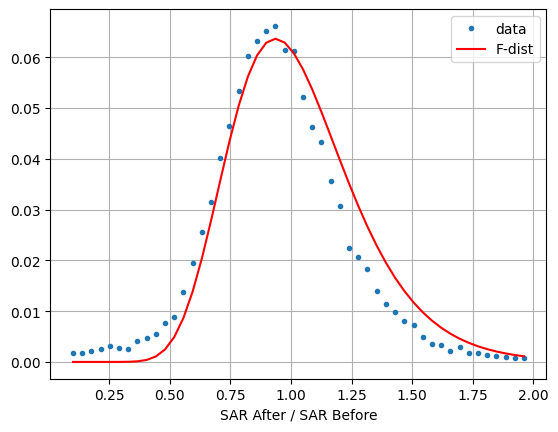

In [157]:
# Load in SAR data, just the VV band for now

# Calculate some statistics
# We reduce the region to a smaller geometry (of the rural area) because otherwise computation is extremely slow
hist = ratio_SAR.reduceRegion(ee.Reducer.fixedHistogram(0.1,2.0,50), rural_aoi, bestEffort=True).get('VV').getInfo()
mean = ratio_SAR.reduceRegion(ee.Reducer.mean(), rural_aoi, bestEffort=True).get('VV').getInfo()
variance = ratio_SAR.reduceRegion(ee.Reducer.variance(), rural_aoi, bestEffort=True).get('VV').getInfo()

m = 30

# Plot the histogram
h = np.array(hist)
x = h[:, 0]
y = h[:, 1] / np.sum(h[:, 1])
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 25, '-r', label='F-dist')
plt.legend()
plt.xlabel("SAR After / SAR Before")
plt.show()

This distribution is pretty well fit by an F-distribution with m = 30, so that's what we will assume for our hypothesis test

In [153]:
%load_ext autoreload
%autoreload 2

from hypothesis_testing import create_hypothesis_test_map as create_hypothesis_test_map

threshold = 0.05

SAR_hypo_map = create_hypothesis_test_map(before_image_SAR.select('VV'), after_image_SAR.select('VV'), aoi, 30, threshold)
display(SAR_hypo_map)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We have to set a pretty low threshold (0.05) for even the lake change to show up as statistically significant compared to other, smaller-scale changes. These other changes are almost at the resolution of the image, so I wonder whether they are specific to using just the VV band, or whether they reflect small changes in the landscape due to mudslides, etc. The latter is possible, since the changes are most prominently located in mountainous terrain that received lots of rainfall. 

Bivariate Change Detection -- Utilizing both VV and VH bands together

In [158]:
def det(im):
  return im.expression('b(0) * b(1)')

# number of looks
m = 5

def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

im1 = before_image_SAR.select('VV','VH')
im2 = after_image_SAR.select('VV','VH')

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=11)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())

Above shows the p-value from 0 (black) to 1 (white), where small p-values indicate change. Let's mask out p-values smaller than some threshold...

In [162]:
mp = folium.Map(location=location, zoom_start=11)
c_map = p_value.multiply(0).where(p_value.lt(0.5), 1)
mp.add_ee_layer(c_map.updateMask(
    c_map.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'c_map')
mp.add_child(folium.LayerControl())

This is a bit of speckle-y mess but as you increase the threshold, more changes become apparent. It's still unclear what these changes correlate with; unless the threshold is really high, they don't overlap with the lake, which we know went through significant change. 

The direction of change is also unclear. Since we've combined both VV and VH bands, whether changes are caused by increases/decreases in just one band or in both makes this hard to tell from our analysis so far. To see the change direction more clearly, we can fold in the Loewner order, which tells us whether our covariance matrix is positive definite, negative definite, or otherwise indefinite. 

In [167]:
c_map = p_value.multiply(0).where(p_value.lt(0.5), 1)
diff = im2.subtract(im1)
d_map = c_map.multiply(0)                    # Initialize the direction map to zero.
d_map = d_map.where(det(diff).gt(0), 2)      # All pos or neg def diffs are now labeled 2.
d_map = d_map.where(diff.select(0).gt(0), 3) # Re-label pos def (and label some indef) to 3.
d_map = d_map.where(det(diff).lt(0), 1)      # Label all indef to 1.
c_map = c_map.multiply(d_map)                # Re-label the c_map, 0*X = 0, 1*1 = 1, 1*2= 2, 1*3 = 3.

In [168]:
mp = folium.Map(location=location, zoom_start=11)
mp.add_ee_layer(
    c_map.updateMask(c_map.gt(0)), {
        'min': 0,
        'max': 3,
        'palette': ['black', 'yellow', 'blue', 'red']
    }, 'c_map')
mp.add_child(folium.LayerControl())

The above map has positive definite red, negative definite blue, and indefinite yellow. Putting the threshold up to 0.5 (which is not a very significant change threshold), one can now see a few trends. For instance, the blue regions of the map, which correspond to negative definite pixel changes, are strongly correlated with water. This indicates a decreasing reflectance in both VV and VH bands, which in agricultural settings correlates with crop harvesting; here, it makes sense that flooding, which swallows up scattering vegetation and decreases reflectance, would have a similar effect. Red, on the other hand, which are positive definite pixel changes, occur more in the marshland around Lake Cachuma. 

Further from the lake, the trends aren't as clear, as blue is prevalent in the foothill slopes near Santa Barbara, as well as red and yellow.

## Sequential change detection (under construction)
Finally, let's follow part 3 of the GEE tutorial on SAR change detection and see WHEN these changes occurred. That will help us tie them to different likely stages that happened between November and March, e.g. the initial flood and mudslide stage, the subsequent growth of vegetation, and anything else. 

A disclaimer again: the following Python routines are not my own. They are from https://developers.google.com/earth-engine/tutorials/community/detecting-changes-in-sentinel-1-imagery-pt-3 and simply applied to the Santa Barbara region.